In [1]:
import sys
sys.path.append("..")
sys.path.append("../datasets")
import torch
import torch
from torch.nn import functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

from rasp_models.triplets import get_triplets_model
from tracr.haiku_to_pytorch import haiku_to_pytorch


from datasets.dataloaders import makeTripletsDataLoader
from torchinfo import summary

In [ ]:
loader = makeTripletsDataLoader(max_seq_len=50)

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = get_triplets_model(max_seq_len=50)
torch_model = haiku_to_pytorch(model).to(DEVICE)

In [4]:
def evaluate(model, data):
    inputs, outputs = data[0]

    model_output = model.forward(inputs)

    if torch.isnan(sum(sum(sum(model_output)))):
        print(inputs)
        print(outputs)
        print(model_output)

    loss = F.cross_entropy(model_output, outputs)
    return loss, {
        "logits": model_output
    }

In [5]:
summary(torch_model)

Layer (type:depth-idx)                   Param #
TracrTransformer                         --
├─ModuleList: 1-1                        --
│    └─TracrBlock: 2-1                   --
│    │    └─TracrAttention: 3-1          8,317
│    │    └─TracrMLP: 3-2                20,776
│    └─TracrBlock: 2-2                   --
│    │    └─TracrAttention: 3-3          8,317
│    │    └─TracrMLP: 3-4                20,776
Total params: 58,186
Trainable params: 58,186
Non-trainable params: 0

In [6]:
for _ in range(9):
    learning_coeff_stats = estimate_learning_coeff_with_summary(
        torch_model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=1e-5, localization=1.0, nbeta=default_nbeta(loader)),
        num_chains=10,  # How many independent chains to run
        num_draws=100,  # How many samples to draw per chain
        num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=1,  # How many steps to take between each sample
        device=DEVICE,
        online=True,
    )
    trace = learning_coeff_stats["loss/trace"]
    print(round(sum(learning_coeff_stats['llc/means'])/len(learning_coeff_stats['llc/means']), 2))

/Users/njay/CS/Research/llc-interpretability/.venv/lib/python3.13/site-packages/devinterp/utils.py:88: UserWarning: default nbeta is undefined for batch_size * grad_accum_steps == 1, falling back to default value of 1
  warnings.warn(
/Users/njay/CS/Research/llc-interpretability/.venv/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/njay/CS/Research/llc-interpretability/.venv/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/njay/CS/Research/llc-interpretability/.venv/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness fr

0.83


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 108.30it/s]


0.82


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 107.82it/s]


1.03


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 108.15it/s]


1.05


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 107.46it/s]


0.95


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 107.72it/s]


1.04


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 108.27it/s]


1.21


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 107.05it/s]


1.02


Chain 9: 100%|██████████| 100/100 [00:01<00:00, 99.63it/s]

1.04


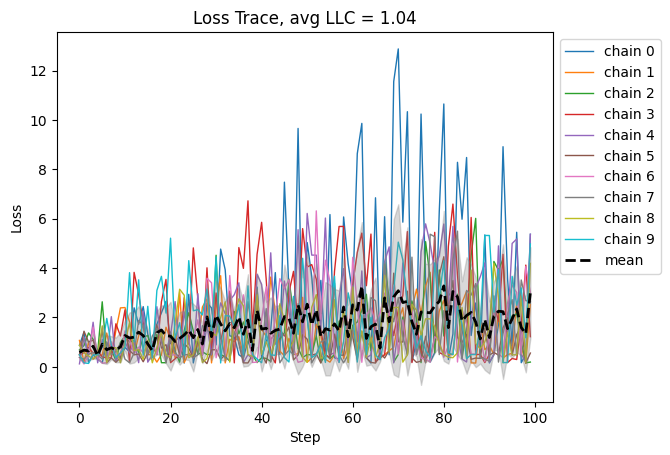

<Figure size 1200x900 with 0 Axes>

In [7]:
plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)